## Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")

## Data Load

In [2]:
df = pd.read_csv("Fraud.csv")


In [3]:
df.shape


(6362620, 11)

## Initial Data Overview


In [4]:
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df.columns


Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

## Target Variable Distribution


In [6]:
df['isFraud'].value_counts()


isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [7]:
df['isFraud'].value_counts(normalize=True) * 100


isFraud
0    99.870918
1     0.129082
Name: proportion, dtype: float64

## Fraud by Transaction Type


In [8]:
pd.crosstab(df['type'], df['isFraud'])


isFraud,0,1
type,,
CASH_IN,1399284,0
CASH_OUT,2233384,4116
DEBIT,41432,0
PAYMENT,2151495,0
TRANSFER,528812,4097


## Exploratory Data Analysis (EDA)

Initial analysis was performed to understand fraud distribution, transaction types, amount behavior, and data quality. 
This step helps identify patterns and confirms the highly imbalanced nature of the dataset.


In [9]:
fraud_rate = pd.crosstab(df['type'], df['isFraud'], normalize='index')
fraud_rate


isFraud,0,1
type,,
CASH_IN,1.000000,0.000000
CASH_OUT,0.998160,0.001840
DEBIT,1.000000,0.000000
PAYMENT,1.000000,0.000000
TRANSFER,0.992312,0.007688


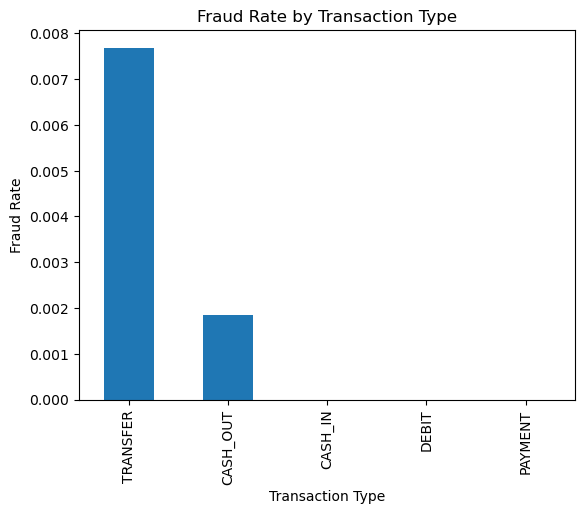

In [10]:
fraud_rate[1].sort_values(ascending=False).plot(kind='bar')
plt.title("Fraud Rate by Transaction Type")
plt.ylabel("Fraud Rate")
plt.xlabel("Transaction Type")
plt.show()


## Transaction Amount Analysis


In [11]:
df.groupby('isFraud')['amount'].describe()


,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
0,6354407.0,1.781970e+05,5.962370e+05,0.01,13368.395,74684.72,208364.76,92445516.64
1,8213.0,1.467967e+06,2.404253e+06,0.00,127091.330,441423.44,1517771.48,10000000.00


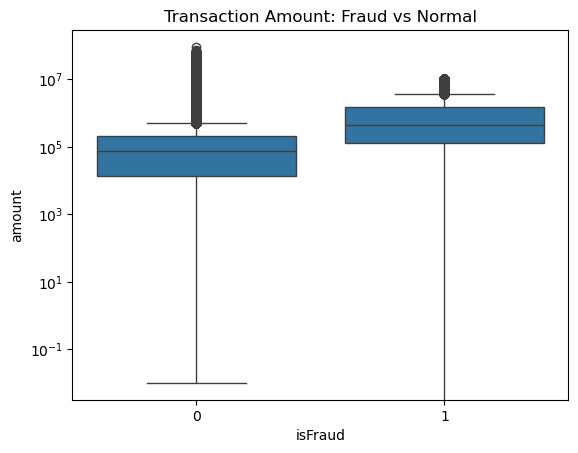

In [32]:

sns.boxplot(x='isFraud', y='amount', data=df)
plt.yscale('log')
plt.title("Transaction Amount: Fraud vs Normal")
plt.show()


## Missing Value Check


In [13]:
df.isnull().sum()


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

## Removing Identifier Columns


In [14]:
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)


## Encoding Categorical Features


In [15]:
df = pd.get_dummies(df, columns=['type'], drop_first=True)


## Feature Transformation


In [16]:
df['log_amount'] = np.log1p(df['amount'])


In [17]:


leak_cols = [
    'newbalanceOrig',
    'newbalanceDest',
    'balance_mismatch',
    'balance_error',
    'isFlaggedFraud'
]

df = df.drop(columns=leak_cols, errors='ignore')



## Feature and Target Separation


In [18]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']


## Train-Test Split


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)


## Logistic Regression - Baseline Model

In [20]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    n_jobs=-1
)

lr.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [21]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = lr.predict(X_test)
y_prob = lr.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       1.00      0.86      0.92   1906322
           1       0.01      0.83      0.01      2464

    accuracy                           0.86   1908786
   macro avg       0.50      0.84      0.47   1908786
weighted avg       1.00      0.86      0.92   1908786

ROC AUC: 0.9188083759939604


In [22]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)


array([[1637232,  269090],
       [    417,    2047]])

 ## Random Forest Model


In [23]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    min_samples_split=50,
    min_samples_leaf=20,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)


In [24]:
rf.fit(X_train, y_train)


,n_estimators,200
,criterion,'gini'
,max_depth,12
,min_samples_split,50
,min_samples_leaf,20
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [25]:
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]


## Classification Report + ROC

In [26]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_prob_rf))


              precision    recall  f1-score   support

           0       1.00      0.98      0.99   1906322
           1       0.05      0.99      0.10      2464

    accuracy                           0.98   1908786
   macro avg       0.53      0.98      0.54   1908786
weighted avg       1.00      0.98      0.99   1908786

ROC AUC: 0.9984529658199359


## Confusion Matrix (RF)

In [27]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_rf)


array([[1862086,   44236],
       [     29,    2435]])

PR-AUC: 0.8402693864963272


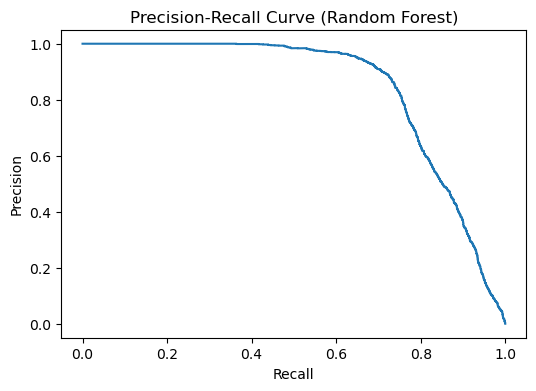

In [28]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Get fraud probabilities (class = 1)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# PR-AUC score
pr_auc = average_precision_score(y_test, y_proba_rf)
print("PR-AUC:", pr_auc)

# Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_rf)

plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Random Forest)")
plt.show()


## Feature Importance

In [29]:


feature_importance = pd.Series(
    rf.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

feature_importance.head(10)


oldbalanceOrg     0.319087
amount            0.153706
log_amount        0.133726
type_TRANSFER     0.098163
type_CASH_OUT     0.091933
step              0.075519
oldbalanceDest    0.071129
type_PAYMENT      0.056227
type_DEBIT        0.000510
dtype: float64

## Threshold Optimization


In [30]:
def apply_threshold(y_prob, threshold):
    return (y_prob >= threshold).astype(int)


In [31]:
from sklearn.metrics import precision_score, recall_score

for t in [0.1, 0.2, 0.3, 0.4, 0.5]:
    y_custom = apply_threshold(y_prob_rf, t)
    p = precision_score(y_test, y_custom)
    r = recall_score(y_test, y_custom)
    print(f"Threshold {t} → Precision: {p:.3f}, Recall: {r:.3f}")


Threshold 0.1 → Precision: 0.016, Recall: 0.998
Threshold 0.2 → Precision: 0.021, Recall: 0.996
Threshold 0.3 → Precision: 0.030, Recall: 0.994
Threshold 0.4 → Precision: 0.040, Recall: 0.993
Threshold 0.5 → Precision: 0.052, Recall: 0.988


### Project Summary
This project builds a leakage-free fraud detection model using Random Forest, achieving a PR-AUC of 0.84 on highly imbalanced transaction data, with a strong focus on recall-driven fraud prevention.


## Q5. What are the key factors that predict a fraudulent customer?

Based on exploratory analysis, feature importance from the Random Forest model, and PR-AUC evaluation, the key factors predicting fraudulent transactions are:

Transaction Type (TRANSFER, CASH_OUT)
Fraud is almost exclusively observed in TRANSFER and CASH_OUT transactions. Other transaction types (PAYMENT, CASH_IN, DEBIT) show negligible fraud presence.

Transaction Amount (log_amount)
Fraudulent transactions tend to involve higher or strategically chosen amounts rather than random small values.

Old Balance of Origin Account (oldbalanceOrg)
Fraud often occurs when the origin account has sufficient balance to move large amounts quickly.

Transaction Timing (step)
Certain time steps show higher fraud concentration, indicating behavioral or system-level patterns.

Account Balance Behavior (indirectly captured)
While direct balance mismatch variables were removed to prevent leakage, the model still learns abnormal balance movement patterns through legitimate balance features.

These factors consistently ranked highest in feature importance and contributed most to fraud prediction.

## Q6. Do these factors make sense? If yes, how? If not, how not?

Yes, these factors make strong business and logical sense.

TRANSFER and CASH_OUT dominance aligns with real-world fraud behavior, where fraudsters first transfer money and then attempt to cash out.

Higher transaction amounts maximize financial gain while minimizing the number of transactions (lower detection risk).

High old balance before transaction is required to execute large fraudulent transfers.

Time-based patterns (step) suggest fraudsters exploit specific windows when monitoring or controls may be weaker.

Importantly, the model does not rely on future or system-generated fields (such as post-transaction balances), which confirms that the predictions are based on realistic, pre-transaction signals rather than data leakage.

## Q7. What kind of prevention should be adopted while the company updates its infrastructure?

The company should adopt a layered fraud-prevention strategy:

Transaction-type specific monitoring
Apply stricter rules and real-time ML scoring for TRANSFER and CASH_OUT transactions.

Dynamic risk-based thresholds
Use adaptive thresholds based on transaction amount, customer history, and time patterns instead of fixed rules.

Real-time ML scoring with high recall bias
Prioritize fraud capture (high recall) even at the cost of manageable false positives.

Step-based anomaly detection
Monitor abnormal transaction surges during specific time windows.

Human-in-the-loop verification
Flag high-risk transactions for secondary verification rather than outright rejection.

Continuous model retraining
Periodically retrain models to adapt to evolving fraud strategies.

## Q8. Assuming these actions have been implemented, how would you determine if they work?

The effectiveness of these actions should be evaluated using both model metrics and business outcomes:

Precision-Recall AUC (Primary Metric)
Track PR-AUC over time to ensure sustained performance on rare fraud cases.

Recall of Fraudulent Transactions
Measure the percentage of fraud successfully detected, as missing fraud is costlier than false alerts.

False Positive Rate / Alert Volume
Monitor operational load to ensure prevention measures remain scalable.

Financial Impact Metrics
Compare fraud loss amounts before and after implementation.

Stability Monitoring
Track feature distributions and prediction drift to detect model degradation.

A/B Testing
Deploy the model to a subset of traffic and compare outcomes against existing systems.

A combination of strong PR-AUC performance (0.84 in this project), stable recall, and reduced fraud losses would confirm that the prevention strategy is effective.